In [1]:
import numpy as np

First, let me start this with something simple.

Let me consider y = x*2. If I want to compute dy/dx, I know the answer should be 2. But how would an autograd system compute this?

In [2]:
# Value class

class ValueOld:
    def __init__(self, data):
        self.data = data
        self.grad = 0
        self._op = None
        self._inputs = []
    
    def __mul__(self, other):
        if not isinstance(other, ValueOld):
            other = ValueOld(other)
        result = ValueOld(self.data * other.data)
        result._op = 'mul'
        result._inputs = [self, other]
        return result
    
    def backward(self):
        self.grad = 1

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._inputs:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)

        for v in reversed(topo):
            if v._op == 'mul':
                a, b = v._inputs
                a.grad += v.grad * b.data
                b.grad += v.grad * a.data

In [3]:
x = ValueOld(3)
y = x * 2
z = y * 5

In [4]:
z.backward()

In [5]:
print(y.grad)

5


In [6]:
print(x.grad)

10


Time to add all the basic arithmetic operations (addition, subtraction, multiplication, division).

In [7]:
class Value:
    """
    A Value object represents a single scalar value in the computation graph.
    It stores the value itself, its gradient, and the operation that produced
    it. Currently, this class supports arithmetic operations
    (addition, subtraction, multiplication, division) and provides methods
    for backpropagation.

    Further note to myself: Subtraction operation can be optimized to act like
    addition operations, so I can just get rid of the backward pass for it
    since the addition backward pass calculates the gradient correctly by
    virtue of the __neg__ method. However, for the sake of learning and
    creating a visual computation graph using the '-' symbol, I am not doing
    those at the moment. In the future, sure.
    """

    def __init__(self, data, _op="", label=""):
        self.data = data
        self.grad = 0.0
        self.label = label if label else str(data)
        self._op = _op
        self._inputs = []

    def __repr__(self):
        return f"Value.data = {self.data}"

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other, label=str(other))
        result = Value(self.data + other.data, _op="+")
        result._inputs = [self, other]
        return result

    def __sub__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        result = Value(self.data - other.data, _op="-")
        result._inputs = [self, other]
        return result

    def __neg__(self):
        """
        Since the subtraction method `__sub__` in our Value class is
        implemented as `self + (-other)`, when we do `a - b`, Python converts
        it to `a + (-b)`. As a result, the `-b` part triggers the `__neg__`
        method on `b`. `__neg__` thus converts the value to its negative by
        multiplying by -1.
        """
        return self * (-1)

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other, label=str(other))
        result = Value(self.data * other.data, _op="*")
        result._inputs = [self, other]
        return result

    def __rmul__(self, other):
        """
        This is a special method that allows us to multiply a `Value` object
        from the right side. For example, it lets us write `2 * x` where `x`
        is a `Value`, instead of just `x * 2`. This is part of Python's special
        method protocol - when Python sees `2 * x`, it first tries to call
        `2.__mul__(x)`, and if that fails (which it will since numbers don't
        know about our `Value` class), it falls back to calling
        `x.__rmul__(2)`. This is known as the "reflected" or "reversed"
        multiplication operation.
        """
        return self * other

    def __radd__(self, other):
        """
        This is a special method that allows us to add a `Value` object from
        the right side. For example, it lets us write `2 + x` where `x` is a
        `Value`, instead of just `x + 2`. This is part of Python's special
        method protocol - when Python sees `2 + x`, it first tries to call
        `2.__add__(x)`, and if that fails (which it will since numbers don't
        know about our `Value` class), it falls back to calling
        `x.__radd__(2)`. This is known as the "reflected" or "reversed"
        addition operation.
        """
        return self + other

    def __truediv__(self, other):
        """
        This is a special method that implements division for `Value` objects.
        When Python sees an expression like `a / b` where `a` is a `Value`
        object, it calls this method. This method:
        1. Converts the divisor to a `Value` object if it isn't one already
        2. Creates a new `Value` object with the quotient of the data values
        3. Records the division operation & input values for use in backpropagation

        For example:

        ```python
        x = Value(8)
        y = Value(2)
        z = x / y  # z will be Value(4.0)
        ```

        The division operation is important for neural networks as it's used
        in operations like normalization and computing averages. During
        backpropagation, the gradient computation for division follows the
        quotient rule from calculus.
        """
        if not isinstance(other, Value):
            other = Value(other, label=str(other))
        result = Value(self.data / other.data, _op="/")
        result._inputs = [self, other]
        return result

    def __rtruediv__(self, other):
        """
        This is a special method that allows us to divide a `Value` object
        from the right side. For example, it lets us write `2 / x` where `x`
        is a `Value`, instead of just `x / 2`. This is part of Python's
        special method protocol - when Python sees `2 / x`, it first tries to
        call `2.__truediv__(x)`, and if that fails (which it will since
        numbers don't know about our `Value` class), it falls back to calling
        `x.__rtruediv__(2)`. This is known as the "reflected" or "reversed"
        division operation. Note that for division, the order matters - `a/b`
        is not the same as `b/a`, which is why we flip the operands here.
        """
        if not isinstance(other, Value):
            other = Value(other, label=str(other))
        result = Value(other.data / self.data, _op="/")
        result._inputs = [other, self]
        return result

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._inputs:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for v in reversed(topo):
            if v._op == "+":
                a, b = v._inputs
                a.grad += (
                    v.grad * 1
                )  # v.grad is an upstream gradient, 1 is the local gradient
                b.grad += v.grad * 1

            elif v._op == "-":
                a, b = v._inputs
                a.grad += (
                    v.grad * 1
                )  # v.grad is an upstream gradient, 1 is the local gradient
                b.grad += v.grad * -1

            elif v._op == "*":
                a, b = v._inputs
                # v.grad is an upstream gradient, b.data is the local gradient
                a.grad += v.grad * b.data
                b.grad += v.grad * a.data

            elif v._op == "/":
                a, b = v._inputs
                # v.grad is an upstream gradient, 1/b.data the local gradient
                a.grad += v.grad * (1 / b.data)
                b.grad += v.grad * (-a.data / (b.data) ** 2)


In [8]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._inputs:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f"{{ {n.label} | data: {n.data:.2f} | grad: {n.grad:.2f} }}", shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [9]:
a = Value(2.0, label='a')
b = a * 3.0; b.label = 'b'
c = a / 3.0; c.label = 'c' 
d = 4*b*c; d.label = 'd'
e = d - a; e.label = 'e'


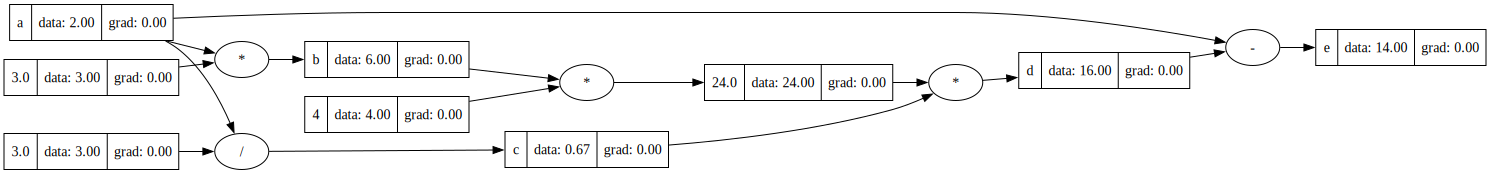

In [10]:
draw_dot(e)

In [11]:
e.backward()

In [12]:
a, b, c, d, e

(Value.data = 2.0,
 Value.data = 6.0,
 Value.data = 0.6666666666666666,
 Value.data = 16.0,
 Value.data = 14.0)

Awesome! Now that I have manually calculated the gradients across the computation graph (through the Value class, on my physical notebook, and verifying them all with PyTorch's `backward`), let me try and implement a very simple squared error loss.

In [13]:
target = Value(3.0, label='target')
pred = Value(2.0, label='pred')

diff = pred - target

loss = diff * diff # I realize here that I should add pow to the Value class too, but will do that later

In [14]:
diff

Value.data = -1.0

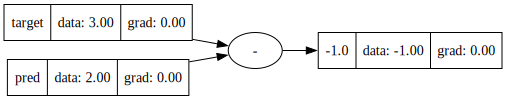

In [15]:
draw_dot(diff)

In [16]:
loss.backward()

Very short and sweet. Now, I will have to start accelerating. From here, I am planning to:

1. Extend the `Value` class to support scalars as well as tensors.
2. Add `pow` to the `Value` class.
3. Add `MSE` loss to the `Value` class.
4. Create a `Linear` class that will be used to create a simple linear layer.

Also, important but from here, I will start importing the `Value` class from the `value.py` file that is in this same directory.


In [17]:
from value import Value
from linear import Linear
from loss import MSELoss
from comp_graph_viz import draw_dot

<img src="https://miro.medium.com/v2/resize:fit:730/0*MdRLxfy4GbQlv97V." alt="MSE Loss" style="width: 450px; height: 300px;" />

In [18]:
# just as an example:

# Create input and target (2x2 matrices)
x = Value([[1.0, 2.0], [3.0, 4.0]], label='x')  # Input
y_true = Value([[0.8, 1.2], [2.5, 3.0]], label='y_true')  # Target

# Forward pass
linear_layer = Linear(in_features=2, out_features=2)
y_pred = linear_layer(x)          # Matrix multiply then add bias
loss = MSELoss()(y_pred, y_true)

In [19]:
linear_layer.parameters()

[Value(data=[[ 0.06780417  0.41805926]
  [-0.43179261 -0.59462478]], grad=[[0. 0.]
  [0. 0.]]),
 Value(data=[0. 0.], grad=[0. 0.])]

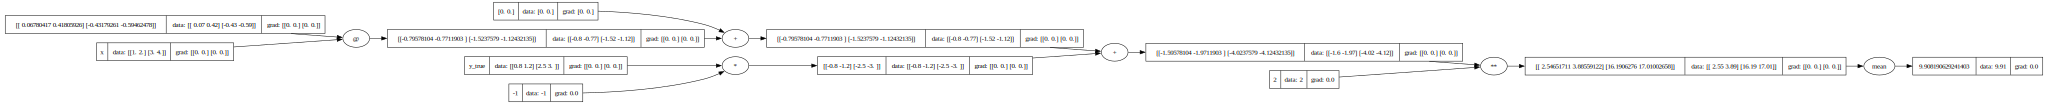

In [20]:
draw_dot(loss)

In [21]:
# Backward pass
loss.backward()

/Users/sumit/playground/sdml/autograd/value.py:227: RuntimeWarning: invalid value encountered in log
  log_term = np.log(base.data + 1e-8)


### Verifying whether this is correct or not through PyTorch

In [ ]:
import torch
import numpy as np
from linear import Linear
from loss import MSELoss
from value import Value

np.random.seed(42)
torch.manual_seed(42)

"""
creating identical input data
"""
batch_size = 3
in_features = 5
out_features = 2

"""
creating numpy array input
"""
x_np = np.random.randn(batch_size, in_features)

"""
creating PyTorch tensor from same data
"""
x_torch = torch.tensor(x_np, dtype=torch.float32, requires_grad=True)

"""
initializing comparable models
"""
# Linear layer initialization
scale = Linear.scale(in_features)
W_np = Linear.init_weights(in_features, out_features, scale)
b_np = Linear.init_bias(out_features)

# PyTorch equivalent
linear_torch = torch.nn.Linear(in_features, out_features, bias=True)

"""
manually setting parameters to match my implementation
"""
with torch.no_grad():
    linear_torch.weight.data = torch.tensor(W_np.T, dtype=torch.float32)  # PyTorch uses weight.T
    linear_torch.bias.data = torch.tensor(b_np, dtype=torch.float32)

"""
forward pass comparison
"""
# my implementation's forward pass (linear.py line 15)

# I am doing this manually since the linear class randomly initializes
# the weights and biases, and I want to match the output with PyTorch's output
y_pred_np = x_np @ W_np + b_np

# PyTorch forward pass
y_pred_torch = linear_torch(x_torch)

"""
loss calculation
"""
target_np = np.random.randn(batch_size, out_features)
target_torch = torch.tensor(target_np, dtype=torch.float32)

# my MSE implementation
loss_np = MSELoss()(y_pred_np, target_np).data
# same as ((y_pred_np - target_np) ** 2).mean()

# PyTorch MSE
loss_torch = torch.nn.MSELoss()(y_pred_torch, target_torch)

"""
backward pass comparison
"""
# running backward on both implementations
loss_torch.backward()

# comparing the results:
print("Forward pass difference:", np.abs(loss_np - loss_torch.item()).item())
print("Weight grad difference:", np.abs(W_np - linear_torch.weight.grad.numpy().T).max())
print("Bias grad difference:", np.abs(b_np - linear_torch.bias.grad.numpy()).max())

TypeError: bad operand type for abs(): 'Value'